In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return time*slope

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time=np.arange(4*365+1, dtype="float32")
baseline=10
series=trend(time, 0.1)
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time, slope)+seasonality(time, period=365, amplitude=amplitude)
series+=noise(time, noise_level, seed=42)

split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

window_size=20
batch_size=32
shuffle_buffer_size=1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
dataset=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0=tf.keras.layers.Dense(1, input_shape=[window_size])
model=tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 533.5820
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 256.9761
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 175.4432
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 134.9751
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 116.8174
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 101.1218
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 91.9161
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 84.6196
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 80.4281
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 77.8562
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 76.5663
Epoch 12/100
31/31

31/31 [==============================] - 0s 1ms/step - loss: 43.9377
Epoch 100/100
31/31 [==============================] - 0s 7ms/step - loss: 44.4460
Layer weights [array([[-0.07678867],
       [ 0.02864704],
       [ 0.06283291],
       [-0.00409583],
       [ 0.02090009],
       [-0.05827653],
       [ 0.0181226 ],
       [-0.02322836],
       [ 0.03397612],
       [ 0.02298116],
       [-0.03597635],
       [ 0.08166788],
       [-0.10208149],
       [-0.00599152],
       [ 0.07192136],
       [ 0.06679959],
       [ 0.00347657],
       [ 0.18717468],
       [ 0.18334761],
       [ 0.520876  ]], dtype=float32), array([0.01342615], dtype=float32)]


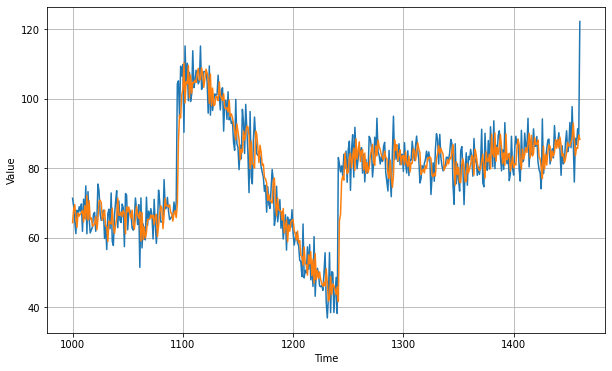

In [16]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0658216